In [23]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms
import torch
from torch import nn
import tqdm
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix
import numpy as np

# dataset = FashionMNIST(root="./data", train=True, download=True, transform=transforms.ToTensor())
# test_data = FashionMNIST(root="./data", train=False, download=True, transform=transforms.ToTensor())

# train_size = int(0.83 * len(dataset))
# val_size = len(dataset) - train_size
# train_dataset, valid_dataset = random_split(dataset, [train_size, val_size])
# batch_size = 256

In [24]:
# trainloader = DataLoader(train_dataset, batch_size=batch_size,
#                                           shuffle=True, num_workers=2)
# validLoader = DataLoader(valid_dataset, batch_size=batch_size,
#                                           shuffle=True, num_workers=2)

In [25]:
# train_dataset[0]
# train_dataset[0][0].shape # 28 x 28 representation of the first image in training data
# train_dataset[0][1] # label of the first image of the training data

In [26]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [27]:
# visualize the images
import matplotlib.pyplot as plt

# plt.imshow(train_dataset[10][0][0])

In [28]:
# 3 most common CNN architectures
# 1. AlexNet
# 2. GoogleNet
# 3. ResNet

In [29]:
import matplotlib.pyplot as plt

def plot_results(train_losses, valid_losses, train_correct, valid_correct, epochs, trainLoader, validLoader):
    # Convert losses from tensors to floats (if needed)
    train_losses = [loss.item() if isinstance(loss, torch.Tensor) else loss for loss in train_losses]
    valid_losses = [loss.item() if isinstance(loss, torch.Tensor) else loss for loss in valid_losses]

    # Convert correct counts to accuracy percentages
    train_acc = [(correct.cpu().item() if torch.is_tensor(correct) else correct) / len(trainLoader.dataset) * 100 for correct in train_correct]
    valid_acc = [(correct.cpu().item() if torch.is_tensor(correct) else correct) / len(validLoader.dataset) * 100 for correct in valid_correct]


    epochs_range = range(1, epochs + 1)

    plt.figure(figsize=(12, 5))

    # Plot Losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label="Train Loss")
    plt.plot(epochs_range, valid_losses, label="Valid Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()

    # Plot Accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_acc, label="Train Accuracy")
    plt.plot(epochs_range, valid_acc, label="Valid Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()




In [30]:
from fastprogress.fastprogress import master_bar, progress_bar
import matplotlib.pyplot as plt
import time

def runModel(train_loader, valid_loader, test_loader, epochs, model, criterion):
    device = DEVICE
    model = model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=.001)
    # A master bar for fancy output progress
    mb = master_bar(range(epochs))

    # # Information for plots
    mb.names = ["Train Loss", "Valid Loss"]
    train_losses = []
    valid_losses = []

    train_correct = []
    valid_correct = []

    start_time = time.time()

    for epoch in mb:

        model.train()

        # train_N = len(train_loader.dataset)
        # num_train_batches = len(train_loader)
        # train_dataiterator = iter(train_loader)

        # train_loss_mean = 0

        trn_corr = 0
        valid_corr = 0

        train_loss = 0
        valid_loss = 0

        #train
        for b, (X_train, y_train) in enumerate(tqdm.tqdm(train_loader)):
            X_train, y_train = X_train.to(device), y_train.to(device)
            b+=1
            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)
            train_loss += loss.item()

            predicted = torch.max(y_pred.data, 1)[1]
            batch_corr = (predicted == y_train).sum()
            trn_corr += batch_corr
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        train_losses.append(train_loss / len(train_loader)) # average accumulated loss per batch
        train_correct.append(trn_corr)
        
        #validation
        model.eval()
        with torch.no_grad():
            for b, (X_valid, y_valid) in enumerate(tqdm.tqdm(valid_loader)):
                X_valid, y_valid = X_valid.to(device), y_valid.to(device)
                y_value = model(X_valid)
                predicted = torch.max(y_value.data, 1)[1]
                valid_corr += (predicted == y_valid).sum()
        
                loss = criterion(y_value, y_valid)
                valid_loss += loss.item()

        valid_losses.append(valid_loss / len(valid_loader))
        valid_correct.append(valid_corr)

        mb.write(f"[{epoch+1}/{epochs}] train loss = {train_losses[epoch]:.4f}; train accuracy = {trn_corr / len(train_loader.dataset) * 100}; valid loss = {valid_losses[epoch]:.4f}; valid accuracy = {valid_corr / len(valid_loader.dataset) * 100}") 

    current_time = time.time()
    total = current_time - start_time
    print(f'Training Took: {(total/60):.2f} minutes!')

        
    plot_results(train_losses, valid_losses, train_correct, valid_correct, epochs, train_loader, valid_loader)

    model.eval()

    all_preds = []
    all_labels = []
    # Test
    # test_losses = []
    test_loss = 0
    test_corr = 0
    # test_correct = []

    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(tqdm.tqdm(test_loader)):
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            y_value = model(X_test)
            predicted = torch.max(y_value.data, 1)[1]
            test_corr += (predicted == y_test).sum()

            loss = criterion(y_value, y_test)
            test_loss += loss.item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_test.cpu().numpy())
    # test_losses.append(loss)
    # test_correct.append(test_corr)

    print(f"avg test loss = {test_loss / len(test_loader):.4f}; test accuracy = {test_corr / len(test_loader.dataset)}") # ADD Accuracy

    cm = confusion_matrix(all_labels, all_preds)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # normalize

    plt.imshow(cm, cmap='Blues')
    plt.title('Confusion Matrix (Normalized)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
              'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    plt.xticks(np.arange(10), labels, rotation=45, ha="right")
    plt.yticks(np.arange(10), labels)

    for i in range(10):
        for j in range(10):
            plt.text(j, i, f"{cm[i, j]:.2f}", ha='center', va='center', color='black')

    plt.colorbar()
    plt.tight_layout()
    plt.show()

    # plot_results(train_losses, valid_losses, train_correct, valid_correct, epochs=epochs)

## AlexNet CNN

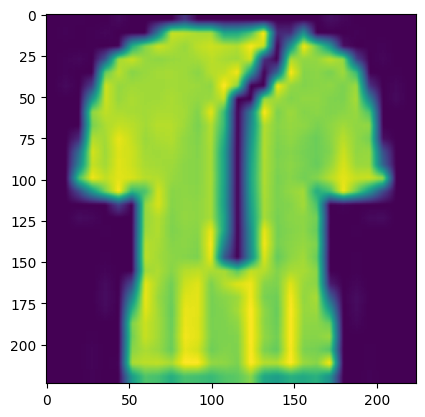

In [31]:
# TRANSFORMS TO 224x224x3
alex_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])

torch.manual_seed(47)

alex_dataset = FashionMNIST(root="./data", train=True, download=True, transform=alex_transforms)
alex_test_dataset = FashionMNIST(root="./data", train=False, download=True, transform=alex_transforms)

train_size = int(0.9 * len(alex_dataset))
val_size = len(alex_dataset) - train_size
alex_train_dataset, alex_valid_dataset = random_split(alex_dataset, [train_size, val_size])
batch_size = 256

# train_dataset = FashionMNIST(root="./data", train=True, download=True, transform=alex_transforms)
# valid_dataset = FashionMNIST(root="./data", train=False, download=True, transform=alex_transforms)

alex_trainLoader = DataLoader(alex_train_dataset, batch_size=256,
                                          shuffle=True, num_workers=0)
alex_validLoader = DataLoader(alex_valid_dataset, batch_size=256,
                                          shuffle=True, num_workers=0)
alex_testLoader = DataLoader(alex_test_dataset, batch_size=256,
                                          shuffle=True, num_workers=0)


plt.imshow(alex_train_dataset[10][0][0])

In [32]:
# AlexNet

alex = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=96, kernel_size=(11, 11), stride=4, padding="valid"),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(3,3), stride=2),

    nn.Conv2d(in_channels=96, out_channels=256, kernel_size=(5, 5), stride=1, padding="same"),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(3,3), stride=2),


    nn.Conv2d(in_channels=256, out_channels=384, kernel_size=(3, 3), stride=1, padding="same"),
    nn.ReLU(),


    nn.Conv2d(in_channels=384, out_channels=384, kernel_size=(3, 3), stride=1, padding="same"),
    nn.ReLU(),


    nn.Conv2d(in_channels=384, out_channels=256, kernel_size=(3, 3), stride=1, padding="same"),
    nn.ReLU(),

    nn.MaxPool2d(kernel_size=(3,3), stride=2),

    nn.Flatten(),
    nn.Linear(6400, 4096),
    nn.Linear(4096, 10),
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:03<00:00,  6.52it/s]


Training Took: 6.54 minutes!


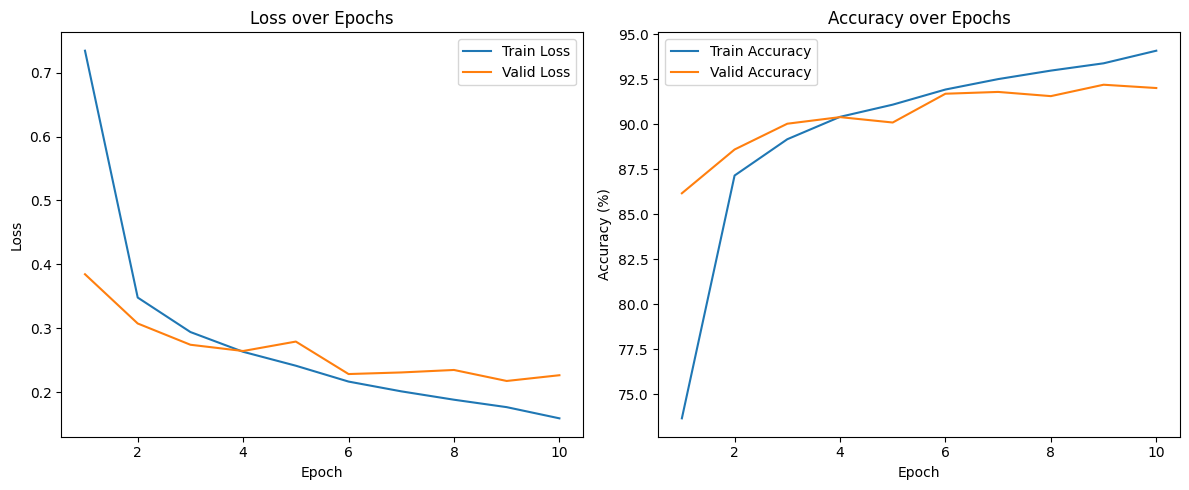

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.49it/s]


avg test loss = 0.2497; test accuracy = 0.914900004863739


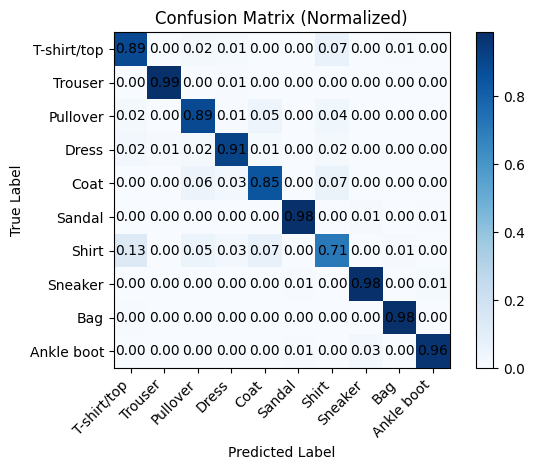

In [33]:
runModel(train_loader=alex_trainLoader, valid_loader=alex_validLoader, test_loader=alex_testLoader, epochs=10, model=alex, criterion=nn.CrossEntropyLoss())      

## LeNet CNN

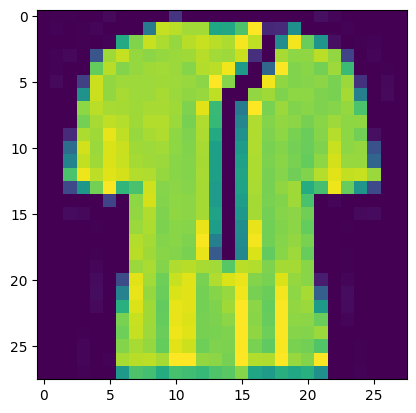

In [34]:
lenet_transforms = transforms.Compose([
    # transforms.Resize(224),
    # transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])

torch.manual_seed(47)

lenet_dataset = FashionMNIST(root="./data", train=True, download=True, transform=lenet_transforms)
lenet_test_dataset = FashionMNIST(root="./data", train=False, download=True, transform=lenet_transforms)

train_size = int(0.9 * len(lenet_dataset))
val_size = len(lenet_dataset) - train_size
lenet_train_dataset, lenet_valid_dataset = random_split(lenet_dataset, [train_size, val_size])
batch_size = 256

lenetTrainLoader = DataLoader(lenet_train_dataset, batch_size=256,
                                          shuffle=True, num_workers=0)
lenetValidLoader = DataLoader(lenet_valid_dataset, batch_size=256,
                                          shuffle=True, num_workers=0)
lenetTestLoader = DataLoader(lenet_test_dataset, batch_size=256,
                                          shuffle=True, num_workers=0)


plt.imshow(lenet_train_dataset[10][0][0])

In [35]:
# LeNet

lenet = nn.Sequential(
    nn.Conv2d(1, 6, 5, padding="same"),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(6, 16, 5, padding="valid"),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(400, 84),
    nn.ReLU(),
    nn.Linear(84, 10),
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 58.38it/s]


Training Took: 0.36 minutes!


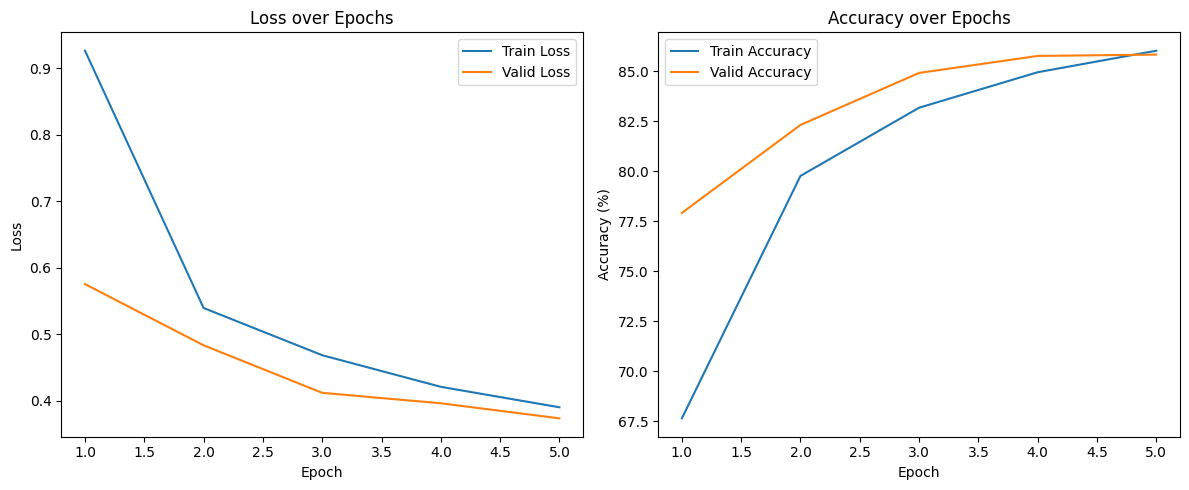

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 59.03it/s]


avg test loss = 0.4086; test accuracy = 0.8533999919891357


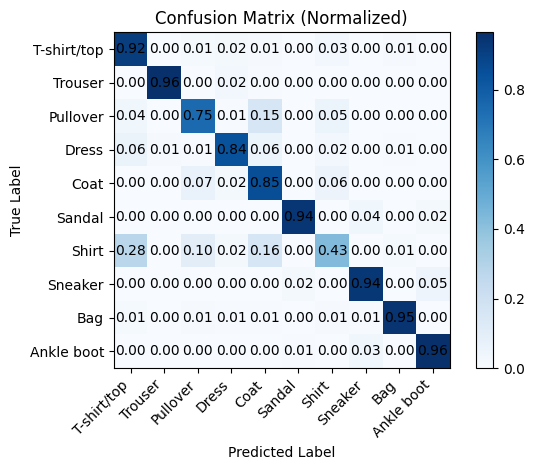

In [36]:
runModel(train_loader=lenetTrainLoader, valid_loader=lenetValidLoader, test_loader=lenetTestLoader, epochs=5, model=lenet, criterion=nn.CrossEntropyLoss())      

## Customized Model - Jukanet

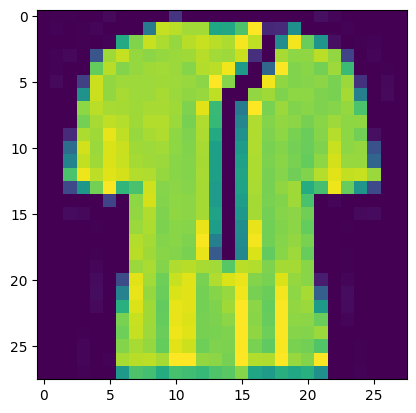

In [37]:
jukanet_transforms = transforms.Compose([
    # transforms.Resize(224),
    # transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])

torch.manual_seed(47)

juka_dataset = FashionMNIST(root="./data", train=True, download=True, transform=jukanet_transforms)
juka_test_dataset = FashionMNIST(root="./data", train=False, download=True, transform=jukanet_transforms)

train_size = int(0.9 * len(juka_dataset))
val_size = len(juka_dataset) - train_size
juka_train_dataset, juka_valid_dataset = random_split(juka_dataset, [train_size, val_size])

jukaTrainLoader = DataLoader(juka_train_dataset, batch_size=256,
                                          shuffle=True, num_workers=0)
jukaValidLoader = DataLoader(juka_valid_dataset, batch_size=256,
                                          shuffle=True, num_workers=0)
jukaTestLoader = DataLoader(juka_test_dataset, batch_size=256,
                                          shuffle=True, num_workers=0)


plt.imshow(juka_train_dataset[10][0][0])

In [38]:
# have more conv layers than lenet (maybe 3 or 4) but keep the size of images as 28x28, use an avg pool layer at the end to smooth edges

jukanet = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=50, kernel_size=(5, 5), stride=1, padding="same"), # out channels averaged btwn alex and lenet size, took lenet kernel size
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2), stride=2),

    nn.Conv2d(in_channels=50, out_channels=64, kernel_size=(5, 5), stride=1, padding="valid"),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2), stride=2),


    nn.Conv2d(in_channels=64, out_channels=72, kernel_size=(5, 5), stride=1, padding="same"),
    nn.ReLU(),


    # nn.Conv2d(in_channels=384, out_channels=384, kernel_size=(3, 3), stride=1, padding="same"),
    # nn.ReLU(),


    # nn.Conv2d(in_channels=384, out_channels=256, kernel_size=(3, 3), stride=1, padding="same"),
    # nn.ReLU(),

    nn.AvgPool2d(kernel_size=(2,2), stride=1),

    nn.Flatten(),
    nn.Linear(72*4*4, 84),
    nn.ReLU(),
    nn.Linear(84, 10),
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 58.56it/s]


Training Took: 0.76 minutes!


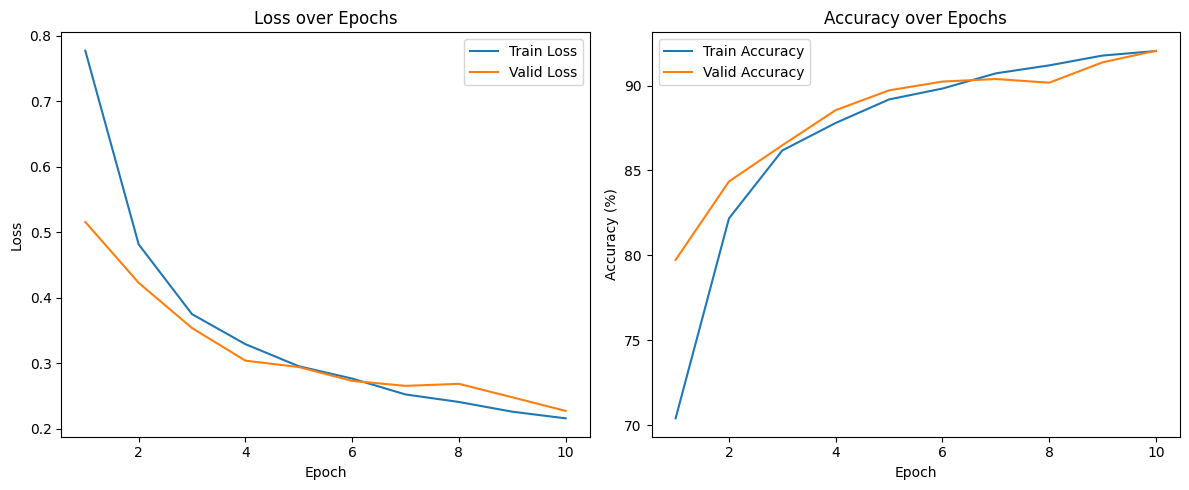

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 47.88it/s]


avg test loss = 0.2511; test accuracy = 0.9063999652862549


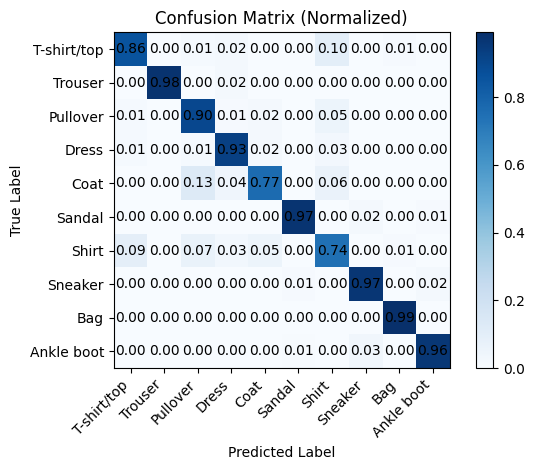

In [39]:
runModel(train_loader=jukaTrainLoader, valid_loader=jukaValidLoader, test_loader=jukaTestLoader, epochs=10, model=jukanet, criterion=nn.CrossEntropyLoss())      

## Jukanet 2

In [40]:
# have more conv layers than lenet (maybe 3 or 4) but keep the size of images as 28x28, use an avg pool layer at the end to smooth edges

jukanet = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=50, kernel_size=(5, 5), stride=1, padding="same"), # out channels averaged btwn alex and lenet size, took lenet kernel size
    nn.BatchNorm2d(50),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2), stride=2),

    nn.Conv2d(in_channels=50, out_channels=64, kernel_size=(5, 5), stride=1, padding="valid"),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2), stride=2),


    nn.Conv2d(in_channels=64, out_channels=72, kernel_size=(5, 5), stride=1, padding="same"),
    nn.BatchNorm2d(72),
    nn.ReLU(),


    # nn.Conv2d(in_channels=384, out_channels=384, kernel_size=(3, 3), stride=1, padding="same"),
    # nn.ReLU(),


    # nn.Conv2d(in_channels=384, out_channels=256, kernel_size=(3, 3), stride=1, padding="same"),
    # nn.ReLU(),

    nn.AvgPool2d(kernel_size=(2,2), stride=1),

    nn.Flatten(),
    nn.Linear(72*4*4, 84),
    nn.ReLU(),
    nn.Linear(84, 10),
)

we just added batch norm 2d
alexnet decreases kernel size as layers progress

  0%|                                                                                                                                                                                                                             | 0/211 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 58.59it/s]


Training Took: 0.84 minutes!


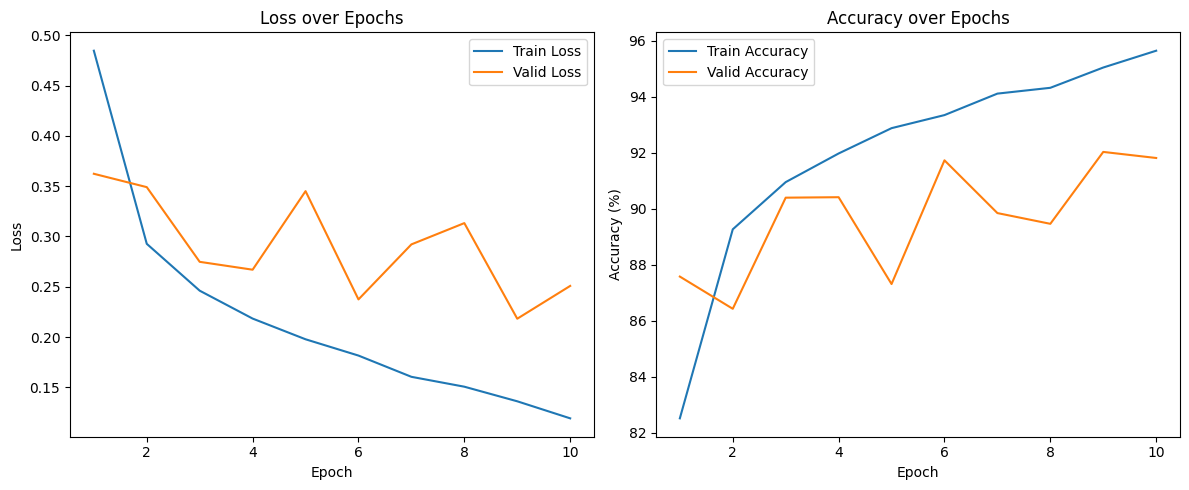

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 58.90it/s]


avg test loss = 0.2751; test accuracy = 0.9150999784469604


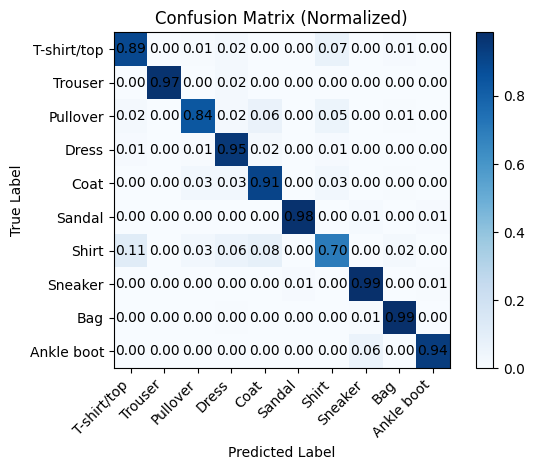

In [41]:
runModel(train_loader=jukaTrainLoader, valid_loader=jukaValidLoader, test_loader=jukaTestLoader, epochs=10, model=jukanet, criterion=nn.CrossEntropyLoss())      

## Jukanet 3

In [42]:
# have more conv layers than lenet (maybe 3 or 4) but keep the size of images as 28x28, use an avg pool layer at the end to smooth edges

jukanet = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=50, kernel_size=(5, 5), stride=1, padding="same"), # out channels averaged btwn alex and lenet size, took lenet kernel size
    nn.BatchNorm2d(50),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2), stride=2),

    nn.Conv2d(in_channels=50, out_channels=64, kernel_size=(3, 3), stride=1, padding="valid"), # 12x12
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2), stride=2), # 6x6


    nn.Conv2d(in_channels=64, out_channels=72, kernel_size=(3, 3), stride=1, padding="same"), # 6x6
    nn.BatchNorm2d(72),
    nn.ReLU(),


    # nn.Conv2d(in_channels=384, out_channels=384, kernel_size=(3, 3), stride=1, padding="same"),
    # nn.ReLU(),


    # nn.Conv2d(in_channels=384, out_channels=256, kernel_size=(3, 3), stride=1, padding="same"),
    # nn.ReLU(),

    nn.MaxPool2d(kernel_size=(2,2), stride=1), # 5x5 bc stride 1

    nn.Flatten(),
    nn.Linear(1800, 84), # 72x5x5=1800
    nn.ReLU(),
    nn.Linear(84, 10),
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 58.59it/s]


Training Took: 0.73 minutes!


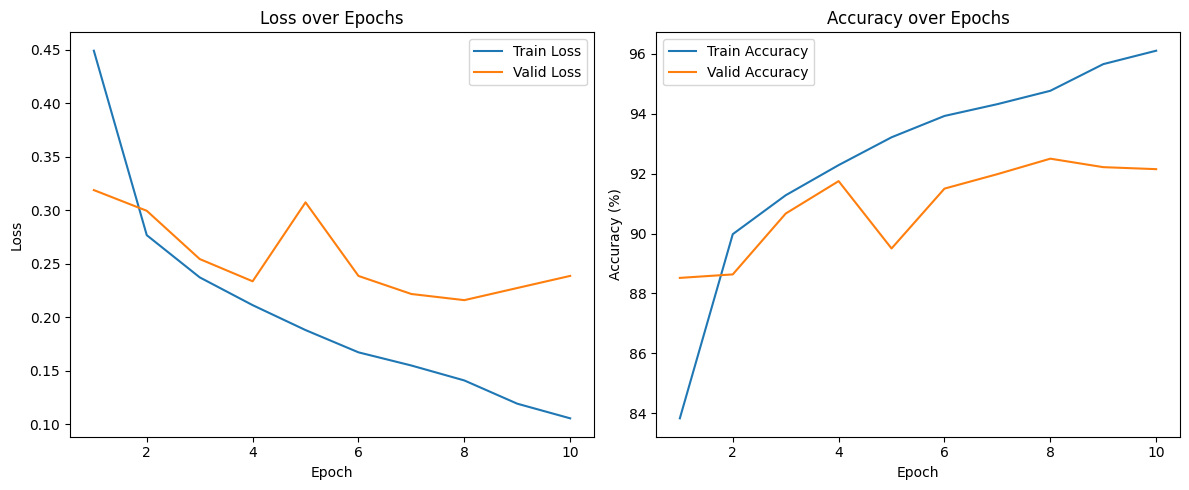

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 59.12it/s]


avg test loss = 0.2638; test accuracy = 0.9146999716758728


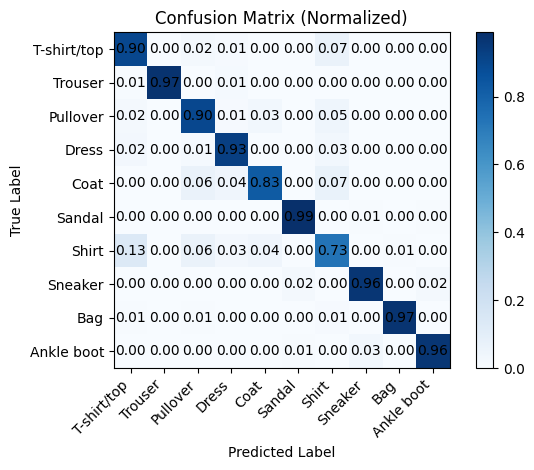

In [43]:
runModel(train_loader=jukaTrainLoader, valid_loader=jukaValidLoader, test_loader=jukaTestLoader, epochs=10, model=jukanet, criterion=nn.CrossEntropyLoss())      